In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %qtconsole
%config InlineBackend.figure_format = 'retina'
# %load_ext line_profiler
# %load_ext memory_profiler

In [2]:
import numpy as np
import dask
import matplotlib.pyplot as plt
import logging
import seaborn as sns

logging.basicConfig(level=logging.INFO)
sns.set_style("white")
sns.set_context("talk")
np.random.seed(0)

## KDE

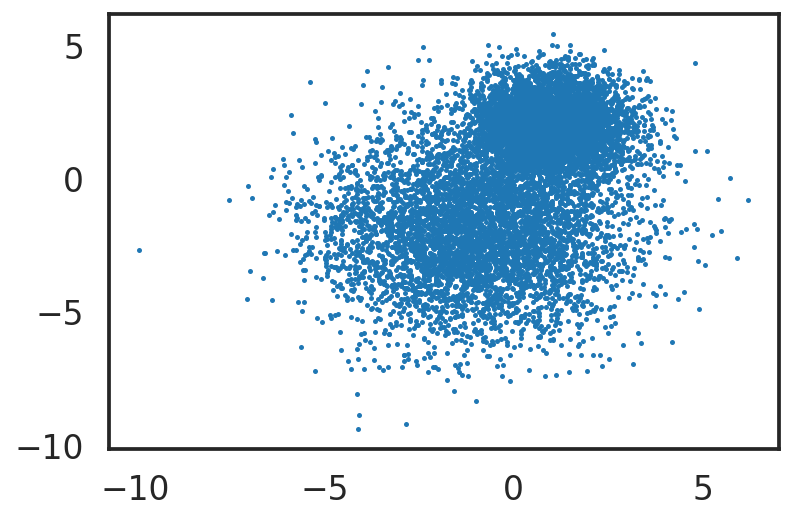

In [3]:
from sklearn.datasets import make_blobs

centers = np.asarray([[1., 2.],
                      [-1., -2.]])
blob, _ = make_blobs(n_samples=10_000, centers=centers, cluster_std=[1, 2])
eval_points = np.linspace(-10, 10)
grid = np.meshgrid(eval_points, eval_points)
x_grid, y_grid = grid
grid = np.stack([g.flat for g in grid], axis=1)
b = np.ones((2,), dtype=np.float64)

plt.scatter(blob[:, 0], blob[:, 1], s=1)

In [4]:
import numba


@numba.jit(nopython=True)
def gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


def numpy_kde(eval_points, samples, bandwidths):
    # This uses a lot of RAM and doesn't scale to larger datasets
    return np.mean(
        np.prod(
            gaussian(((eval_points[np.newaxis, ...] - samples[:, np.newaxis, ...]) / bandwidths)),
        axis=-1),
        axis=0) / np.prod(bandwidths)


# result = numpy_kde(grid, blob, b)

In [5]:
import dask.array as da

def dask_gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def dask_kde(eval_points, samples, bandwidths, chunks_eval=None, chunks_samples=None):
    if chunks_eval is None:
        chunks_eval = ('auto', -1)
    if chunks_samples is None:
        chunks_samples = ('auto', -1)
    rescaled_x = (da.from_array(eval_points, chunks_eval)[np.newaxis, ...] -
                  da.from_array(samples, chunks_samples)[:, np.newaxis, ...]) / bandwidths
    return (da.mean(da.prod(dask_gaussian(rescaled_x), axis=-1), axis=0) / da.prod(bandwidths)).compute()

# result = dask_kde(grid, blob, b, chunks_samples=('auto', -1))

In [6]:
from sklearn.neighbors import KernelDensity

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid)
    return np.exp(log_pdf)


# result = kde_sklearn(blob, grid, bandwidth=1.0)

In [7]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    n_dim = x.shape[1]
    kde = KDEMultivariate(x, bw=bandwidth,
                          var_type='c' * n_dim, **kwargs)
    return kde.pdf(x_grid)

# result = kde_statsmodels_m(blob, grid, bandwidth=b)

In [8]:
import numba

@numba.jit(nopython=True)
def gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


@numba.jit(nopython=True)
def numba_kde(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in range(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(gaussian((eval_points[i] - samples[j]) / bandwidths))
        result[i] /= denom

    return result


result = numba_kde(grid, blob, b)

In [9]:
import numba

@numba.jit(nopython=True)
def gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


@numba.jit(nopython=True, parallel=True, fastmath=True)
def numba_kde_multithread(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(gaussian((eval_points[i] - samples[j]) / bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread(grid, blob, b)

In [10]:
import numba

import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])')
def numba_kde2(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in range(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result

result = numba_kde2(grid, blob, b)

In [11]:
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])', parallel=True, fastmath=True)
def numba_kde_multithread2(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread2(grid, blob, b)

In [12]:
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])', parallel=True)
def numba_kde_multithread2a(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in range(n_eval_points):
        for j in numba.prange(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread2a(grid, blob, b)

In [13]:
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])', parallel=True, fastmath=True)
def numba_kde_multithread2b(eval_points, samples, bandwidths):
    n_samples, n_bandwidths = samples.shape
    n_eval = eval_points.shape[0]

    assert(eval_points.shape[1] == samples.shape[1])
    assert(eval_points.shape[1] == bandwidths.shape[0])

    results = np.zeros((n_eval,))

    for eval_ind in numba.prange(n_eval):
        eval_point = eval_points[eval_ind]
        for sample_ind in range(n_samples):
            product_kde = 1.0
            sample = samples[sample_ind]
            for bandwidth_ind in range(n_bandwidths):
                bandwidth = bandwidths[bandwidth_ind]
                product_kde *= (
                    np.exp(-0.5 *
                           ((eval_point[bandwidth_ind] - sample[bandwidth_ind])
                            / bandwidth)**2) / (bandwidth * SQRT_2PI)
                    / bandwidth)
            results[eval_ind] += product_kde
        results[eval_ind] /= n_samples

    return results

result = numba_kde_multithread2b(grid, blob, b)

In [14]:
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])', parallel=True, fastmath=True, nogil=True)
def numba_kde_multithread2c(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread2c(grid, blob, b)

In [15]:
from sklearn.neighbors import KDTree
import numba


@numba.njit
def fast_intersect(array_collection):
    '''
    https://groups.google.com/a/continuum.io/forum/#!topic/numba-users/2oxtyd4_2iQ
    '''
    for idx in range(len(array_collection)):
        arr_set = set(array_collection[idx])
        if idx == 0:
            result = arr_set
        else:
            result = result.intersection(arr_set)

    return np.array(list(result))


@numba.njit(parallel=True, fastmath=True)
def _interior(eval_points, intersect_ind, samples, bandwidths, denom):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))

    for i in numba.prange(n_eval_points):
        for j in intersect_ind[i]:
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom
    return result


def numba_kde_prod_tree(eval_points, samples, bandwidths, radius):
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)
    ind = [KDTree(samples[:, [dim]]).query_radius(eval_points[:, [dim]], radius[dim])
           for dim in range(samples.shape[1])]
    intersect_ind = [fast_intersect(sample_inds) for sample_inds in zip(*ind)]

    return _interior(eval_points, intersect_ind, samples, bandwidths, denom)


result = numba_kde_prod_tree(grid, blob, b, b * 4.0)

/data2/edeno/anaconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'intersect_ind' of function '_interior'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-15-34f232aa9e42>", line 21:
@numba.njit(parallel=True, fastmath=True)
def _interior(eval_points, intersect_ind, samples, bandwidths, denom):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/data2/edeno/anaconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'intersect__ind' of function '__numba_parfor_gufunc_0x7f31f0345da'.

For more information visit http

In [16]:
import dask.array as da
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

def dask_kde2(eval_points, samples, bandwidths, chunks_eval=None, chunks_samples=None):
    if chunks_eval is None:
        chunks_eval = ('auto', -1)
    if chunks_samples is None:
        chunks_samples = ('auto', -1)

    return (da.mean(da.prod(
        gaussian_pdf(da.from_array(eval_points, chunks_eval)[np.newaxis, ...],
                     da.from_array(samples, chunks_samples)[:, np.newaxis, ...],
                     bandwidths), axis=-1), axis=0) / da.prod(bandwidths)).compute()


# result = dask_kde2(grid, blob, b, chunks_samples=100)

### Speed

In [17]:
%%timeit

result = numpy_kde(grid, blob, b)

2.48 s ± 53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit

with dask.config.set(scheduler='threads'):
    result = dask_kde(grid, blob, b)

1.98 s ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
with dask.config.set(scheduler='processes'):
    result = dask_kde(grid, blob, b)

3.12 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit

result = kde_sklearn(blob, grid, bandwidth=1.0)

1.37 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit

result = kde_sklearn(blob, grid, bandwidth=1.0, rtol=1E-3)

418 ms ± 38.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit

result = kde_statsmodels_m(blob, grid, bandwidth=b)

718 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit

result = numba_kde(grid, blob, b)

7.16 s ± 328 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit

result = numba_kde_multithread(grid, blob, b)

12.8 s ± 333 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit

result = numba_kde2(grid, blob, b)

4.31 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit

result = numba_kde_multithread2(grid, blob, b)

104 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit

result = numba_kde_multithread2a(grid, blob, b)

1.08 s ± 81.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit

result = numba_kde_multithread2b(grid, blob, b)

77.1 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit

result = numba_kde_multithread2c(grid, blob, b)

84.7 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit

result = numba_kde_prod_tree(grid, blob, b, b * 6.0)

607 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Accuracy

In [31]:
np.allclose(numpy_kde(grid, blob, b), dask_kde(grid, blob, b))

True

In [32]:
np.allclose(numpy_kde(grid, blob, b), kde_sklearn(blob, grid, bandwidth=1.0))

True

In [33]:
np.allclose(numpy_kde(grid, blob, b), kde_sklearn(blob, grid, bandwidth=1.0, rtol=1E-3))

False

In [34]:
np.allclose(numpy_kde(grid, blob, b), kde_statsmodels_m(blob, grid, bandwidth=b))

True

In [35]:
np.allclose(numpy_kde(grid, blob, b), numba_kde(grid, blob, b))

True

In [36]:
np.allclose(numpy_kde(grid, blob, b), numba_kde_multithread(grid, blob, b))

True

In [37]:
np.allclose(numpy_kde(grid, blob, b), numba_kde2(grid, blob, b))

True

In [38]:
np.allclose(numpy_kde(grid, blob, b), numba_kde_multithread2(grid, blob, b))

True

In [39]:
np.allclose(numpy_kde(grid, blob, b), numba_kde_multithread2a(grid, blob, b))

False

In [40]:
np.allclose(numpy_kde(grid, blob, b), numba_kde_multithread2b(grid, blob, b))

True

In [41]:
np.allclose(numpy_kde(grid, blob, b), numba_kde_multithread2c(grid, blob, b))

True

In [42]:
np.allclose(numpy_kde(grid, blob, b), numba_kde_prod_tree(grid, blob, b, b * 6.0))

True